In [16]:
library(tidyverse)
library(repr)

In [17]:
tennis_data_raw <- read_csv("data/player_stats.csv")
tennis_data_raw

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



X1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,28 (18-11-1991),United States,Right-handed,Wikipedia,307 (131),213 (31-10-2016),Sekou Bangoura,Two-handed,"$278,709",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,21 (12-05-1998),"Taiwan, Province of China",Right-handed,Wikipedia,232 (205),229 (04-11-2019),Tung Lin Wu,Two-handed,"$59,123",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,25 (29-07-1994),Uzbekistan,Right-handed,Wikipedia,417 (81),253 (17-07-2017),Sanjar Fayziev,Two-handed,"$122,734",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [18]:
names(tennis_data_raw) <- make.names(names(tennis_data_raw), unique = TRUE)
tennis_data_raw_tidied <- tennis_data_raw %>% 
separate(col = Age, into = c("Age", "Birthdate"), sep = " ") %>%
separate(col = Current.Rank, into = c("Current_Rank", "Points_at_Current_Rank"), sep = " ") %>% 
separate(col = Best.Rank, into = c("Best_Rank", "Best_Rank_Date"), sep = " ") %>%
separate(col = Current.Elo.Rank, into = c("Current_Elo_Rank", "Current_Elo_Score"), sep = " ") %>% 
separate(col = Peak.Elo.Rating, into = c("Peak_Elo_Rating", "Date_of_Peak_Elo_Rating"), sep = " ") %>% 
separate(col = GOAT.Rank, into = c("GOAT_Rank", "GOAT_Points"), sep = " ")
tennis_data_raw_tidied

X1,Age,Birthdate,Country,Plays,Wikipedia,Current_Rank,Points_at_Current_Rank,Best_Rank,Best_Rank_Date,⋯,Facebook,Twitter,Nicknames,Grand.Slams,Davis.Cups,Web.Site,Team.Cups,Olympics,Weeks.at.No..1,Tour.Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26,(25-04-1993),Brazil,Right-handed,Wikipedia,378,(97),363,(04-11-2019),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18,(22-12-2001),United Kingdom,Left-handed,Wikipedia,326,(119),316,(14-10-2019),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32,(03-11-1987),Slovakia,Right-handed,Wikipedia,178,(280),44,(14-01-2013),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21,(29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236,(199),130,(10-04-2017),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27,(21-10-1992),Australia,Right-handed,Wikipedia,183,(273),17,(11-01-2016),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22,(11-02-1997),Poland,Right-handed,Wikipedia,31,(1398),31,(20-01-2020),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,28,(18-11-1991),United States,Right-handed,Wikipedia,307,(131),213,(31-10-2016),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,21,(12-05-1998),"Taiwan, Province of China",Right-handed,Wikipedia,232,(205),229,(04-11-2019),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,25,(29-07-1994),Uzbekistan,Right-handed,Wikipedia,417,(81),253,(17-07-2017),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


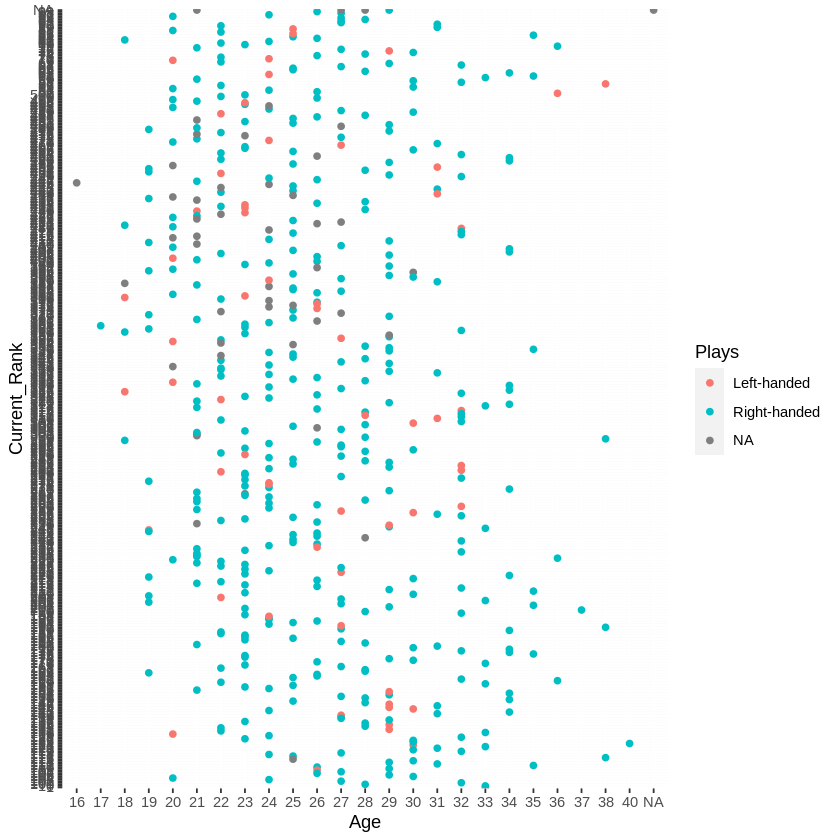

In [36]:
# best_rank_distribution <- ggplot(tennis_data_raw_tidied, aes(x = Best_Rank)) +
# stat_bin(geom = "bar", position = "stack") +
# geom_histogram(stat_bin = "count", binwidth = 100)
# best_rank_distribution
# age_distribution <- ggplot(tennis_data_raw_tidied, aes(x = Age)) +
# geom_histogram(stat = "count", bin = 10)
# age_distribution
current_rank_vs_age <- ggplot(tennis_data_raw_tidied, aes(x = Age, y = Current_Rank, color = Plays)) +
geom_point() 
current_rank_vs_age